# EASY pilot study: Confusion Matrix
This notebook demonstrates how the mask images downloaded for
one annotation study are being processed using both the
[Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
(see particularly Applications section), as well as a
cross-correlation measure operating on the smoothed masks.

In [110]:
# settings
annotationsFolder = 'Annotations'
studyName = 'EasyPilot'
samplingSizeMax = 1024
smoothingKernel = 40.0 # about 1.5 super-pixels -> pixels
minCoeffsPerPair = 3

In [111]:
# imports, etc.
import glob
import imageio
import matplotlib.pyplot as pypl
import numpy as np
import os
import pandas as pd
import re
import scipy.ndimage as ndi

In [112]:
# dice coefficient for images
def image_dice(i1, i2):
    s1 = np.sum(np.ravel(i1))
    s2 = np.sum(np.ravel(i2))
    s12 = np.sum(np.ravel(i1) & np.ravel(i2))
    return 2.0 * (s12 + 0.0) / (s1 + s2 + 0.0)

# cross correlation for images
def image_cc(i1, i2):
    return np.correlate(np.ravel(i1), np.ravel(i2))

# convert lists to confusion matrix (image)
def confusion_matrix(clists):
    ll = len(clists)
    m = np.zeros((ll, ll))
    for m1 in range(ll):
        for m2 in range(m1+1):
            if len(clists[m1][m2]) >= minCoeffsPerPair:
                mv = np.median(clists[m1][m2])
                m[m1, m2] = mv
                m[m2, m1] = mv
    return m

In [113]:
# find annotation mask images
annotationImages = glob.glob('./%s/%s_*.png' % (annotationsFolder, studyName))
print('A total of %s images were found for study %s:' % (len(annotationImages), studyName))

# and determine the (unique) images, annotators, and features
imageNr = []
imageSet = set()
annotator = []
annotatorSet = set()
feature = []
featureSet = set()
reXPattern = re.compile(r'^.*' + studyName + r'_ISIC_(\d+)_([^_]+)_([^_]+)\.png$')
for imageFilename in annotationImages:
    reSearch = reXPattern.search(imageFilename)
    if reSearch:
        reGroups = reSearch.groups()
        imageNr.append(reGroups[0])
        if not reGroups[0] in imageSet:
            imageSet.add(reGroups[0])
        annotator.append(reGroups[1])
        if not reGroups[1] in annotatorSet:
            annotatorSet.add(reGroups[1])
        feature.append(reGroups[2])
        if not reGroups[2] in featureSet:
            featureSet.add(reGroups[2])
    else:
        imageNr.append('')
        annotator.append('')
        feature.append('')
imageList = sorted(imageSet)
annotatorList = sorted(annotatorSet)
featureList = sorted(featureSet)
featureKeys = {}
for f in range(len(featureList)):
    featureKeys[featureList[f]] = f
print(' - a total of %s ISIC images were annotated' % (len(imageList)))
print(' - by %s annotators' % (len(annotatorList)))
print(' - using %s features' % (len(featureList)))
annotDF = pd.DataFrame.from_dict({
    'fileName': annotationImages,
    'imageNr': imageNr,
    'annotator': annotator,
    'feature': feature})

A total of 1925 images were found for study EasyPilot:
 - a total of 140 ISIC images were annotated
 - by 5 annotators
 - using 80 features


In [82]:
# initialize lists of coefficients
diceLists = []
smccLists = []
for l in range(len(featureSet)):
    diceLists.append([[] for x in range(l+1)])
    smccLists.append([[] for x in range(l+1)])

In [86]:
# iterate over images
for i in range(len(imageSet)):
    annoImages = annotDF[annotDF['imageNr'] == imageList[i]]
    numImages = len(annoImages)
    imageMasks = []
    smimageMasks = []
    print('Assessing %s pairs of masks for ISIC_%s' % ((numImages * (numImages-1) // 2), imageList[i]))
    
    # read images and resample if necessary
    for m in range(numImages):
        imageMasks.append(imageio.imread(annoImages.iloc[m]['fileName']).astype('float32'))
        imageShape = imageMasks[-1].shape
        resamplingFactor = 1.0
        if imageShape[0] > samplingSizeMax:
            resamplingFactor = samplingSizeMax / imageShape[0]
        if imageShape[1] > samplingSizeMax:
            resamplingFactor = min(resamplingFactor, samplingSizeMax / imageShape[1])
        if resamplingFactor < 1.0:
            imageMasks[-1] = ndi.zoom(imageMasks[-1], resamplingFactor, order=1)
        smimageMasks.append(ndi.filters.gaussian_filter(imageMasks[-1], smoothingKernel, mode='constant'))
        imageMasks[-1] = imageMasks[-1] >= 64.0
    for m1 in range(1, numImages):
        a1 = annoImages.iloc[m1]['annotator']
        f1 = featureKeys[annoImages.iloc[m1]['feature']]
        for m2 in range(m1):
            a2 = annoImages.iloc[m2]['annotator']
            f2 = featureKeys[annoImages.iloc[m2]['feature']]
            print('.', end='')
            if a1 == a2:
                continue
            if f1 <= f2:
                f1r, f2r = f1, f2
            else:
                f1r, f2r = f2, f1
            dice = image_dice(imageMasks[m1], imageMasks[m2])
            smcc = image_cc(smimageMasks[m1], smimageMasks[m2])
            diceLists[f2r][f1r].append(dice)
            smccLists[f2r][f1r].append(smcc[0])
    print(' done')

Assessing 36 pairs of masks for ISIC_0001115
.................................... done
Assessing 36 pairs of masks for ISIC_0001129
.................................... done
Assessing 91 pairs of masks for ISIC_0001130
........................................................................................... done
Assessing 120 pairs of masks for ISIC_0001149
........................................................................................................................ done
Assessing 91 pairs of masks for ISIC_0001159
........................................................................................... done
Assessing 45 pairs of masks for ISIC_0009926
............................................. done
Assessing 36 pairs of masks for ISIC_0010303
.................................... done
Assessing 66 pairs of masks for ISIC_0010403
.................................................................. done
Assessing 136 pairs of masks for ISIC_0010404
........................

............................................. done
Assessing 78 pairs of masks for ISIC_0014597
.............................................................................. done
Assessing 231 pairs of masks for ISIC_0014599
....................................................................................................................................................................................................................................... done
Assessing 45 pairs of masks for ISIC_0014600
............................................. done
Assessing 45 pairs of masks for ISIC_0014601
............................................. done
Assessing 55 pairs of masks for ISIC_0014602
....................................................... done
Assessing 171 pairs of masks for ISIC_0014603
........................................................................................................................................................................... done
Assessing 10 pai

...................................................................................................................................................................................................................................................................................................................................................................................................................... done
Assessing 15 pairs of masks for ISIC_0016129
............... done
Assessing 276 pairs of masks for ISIC_0016132
.................................................................................................................................................................................................................................................................................... done
Assessing 406 pairs of masks for ISIC_0016133
....................................................................................................................................................

In [114]:
diceCM = confusion_matrix(diceLists)
smccCM = confusion_matrix(smccLists)

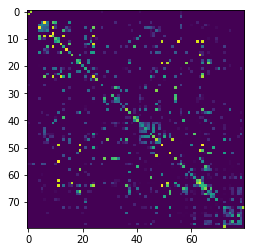

In [115]:
pypl.imshow(diceCM)

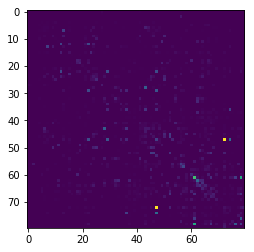

In [116]:
pypl.imshow(smccCM)